# This is a workbook for optimizing the orbital rotation based on the mutual information matrix

In [53]:
from pathlib import Path
from random import random

import numpy as np
import pyscf
import scipy
from pyscf import gto, scf
from scipy.optimize import minimize

from basic_definitions import chemist_to_physicist
from dmrghandler.src.dmrghandler.qchem_dmrg_calc import single_qchem_dmrg_calc
from get_dmrg_config import get_dmrg_process_param, get_dmrg_config, get_dmrg_config_type1
from OrbitalRotation.tools.obt_to_tbt import get_obt_combined_tbt
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

## Hamiltonian preparation
=== The list of Hamiltonians ===
* Molecular Hamiltonians used in the paper such as N_2 or H_2O
* Nearest-neighbour Hubbard model Hamiltonian

In [76]:
mol = gto.M(
        atom=f"O 0 0 0; H  0 1.0 0; H 0 0 1.0",
        basis='sto-3g')
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=1)



print(f"n Cas: {ncas}")
print(f"orb sym: {orb_sym}")
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

absorbed_tbt = pyscf.fci.direct_nosym.absorb_h1e(np.array(h1e.copy()), np.array(g2e.copy()), norb=ncas, nelec=n_elec)
h_in_tbt = pyscf.ao2mo.restore(1, absorbed_tbt.copy(), ncas).astype(np.array(h1e.copy()).dtype, copy=False)
combined_tbt = 0.5 * h_in_tbt
obt_dummy = np.zeros((ncas, ncas))
obt, tbt = chemist_to_physicist(obt_dummy, 0.5 * h_in_tbt)


converged SCF energy = -74.9611711378677
n Cas: 7
orb sym: [0, 0, 0, 0, 0, 0, 0]


In [77]:
def combined_hubbard(t, U, ncas, n_elec):
    """
    The one-body term combined chemist notation of nearest-neighbour Hubbard model Hamiltonian.
    :param t: Hopping term strength
    :param U: Onsite interaction strength
    :param ncas: Number of spatial sites
    :param n_elec: Number of electrons
    :return: 
    """
    tensor = np.zeros((ncas, ncas, ncas, ncas))
    for i in range(ncas - 1):
        for j in range(ncas):
            tensor[i, i + 1, j, j] = - t / (2 * n_elec)
            tensor[i + 1, i, j, j] = - t / (2 * n_elec)
            tensor[j, j, i, i + 1] = - t / (2 * n_elec)
            tensor[j, j, i + 1, i] = - t / (2 * n_elec)
            tensor[i, i, j, j] = - U / (4 * n_elec)
            tensor[j, j, i, i] = - U / (4 * n_elec)
    
    for i in range(ncas):
        tensor[i, i, i, i] = U / 2
    
    return tensor

# t = 1
# U = 1
# ncas = 4
# n_elec = 4

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

# combined_tbt = combined_hubbard(t, U, ncas, n_elec)
# obt_dummy = np.zeros((ncas, ncas))

one_body_tensor, two_body_tensor = chemist_to_physicist(obt_dummy, combined_tbt)


label = "_before"
filename = "fcidump.H2O_10" + f"{label}"
pyscf.tools.fcidump.from_integrals(
    "fcidump_output"/Path(filename),
    one_body_tensor,
    two_body_tensor,
    nmo=one_body_tensor.shape[0],
    nelec=n_elec,
    nuc=ecore,
    ms=spin,
    orbsym=None,
    tol=1E-8,
    float_format=' %.16g',
)

# Apply Orbital Reordering

In [78]:
mol = gto.M(
        atom=f"O 0 0 0; H  0 1.0 0; H 0 0 1.0",
        basis='sto-3g')
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=1)



print(f"n Cas: {ncas}")
print(f"orb sym: {orb_sym}")
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)


idx = driver.orbital_reordering(h1e, g2e)
h1e = h1e[idx][:, idx]
g2e = g2e[idx][:, idx][:, :, idx][:, :, :, idx]
orb_sym = np.array(orb_sym)[idx]

absorbed_tbt = pyscf.fci.direct_nosym.absorb_h1e(np.array(h1e.copy()), np.array(g2e.copy()), norb=ncas, nelec=n_elec)
h_in_tbt = pyscf.ao2mo.restore(1, absorbed_tbt.copy(), ncas).astype(np.array(h1e.copy()).dtype, copy=False)
combined_tbt_optimizing = 0.5 * h_in_tbt
obt_dummy = np.zeros((ncas, ncas))
obt, tbt = chemist_to_physicist(obt_dummy, 0.5 * h_in_tbt)

num_orbitals = ncas
num_electrons = n_elec
num_unpaired = spin
multiplicity = 2 * spin + 1


dmrg_params = get_dmrg_config(
    num_orbitals, num_electrons, num_unpaired,
    multiplicity)

print(num_orbitals)

converged SCF energy = -74.9611711378677
n Cas: 7
orb sym: [0, 0, 0, 0, 0, 0, 0]
7


In [79]:
def prepare_exact_dmrg_config():
    
    dmrg_params = get_dmrg_config_type1(
        num_orbitals, num_electrons, num_unpaired,
        multiplicity)
    
    return dmrg_params

def prepare_dmrg_config():
    
    dmrg_params = get_dmrg_config(
        num_orbitals, num_electrons, num_unpaired,
        multiplicity)
    
    return dmrg_params

## Definitions of the orbital rotation unitary as well as the mutual information cost function

In [80]:
def get_anti_symmetric(n):
    '''
    Construct list of anti-symmetric matrices kappa_pq based on n*(n-1)/2 
    '''
    kappas = []
    for p in range(n):
        for q in range(p+1, n):
            kappa = np.zeros((n, n))
            kappa[p, q] = 1
            kappa[q, p] = -1
            kappas.append(kappa)
    return kappas

def construct_anti_symmetric(n, params):
    '''
    Constrcut the nxn anti-symmetric matrix based on the sum of basis with oparams as coefficients
    '''
    real_anti = get_anti_symmetric(n)
    anti_symm = np.zeros((n, n))
    for idx, antisym in enumerate(real_anti):
        anti_symm += params[idx] * antisym
    return anti_symm

def construct_orthogonal(n, params):
    '''
    The parameters are n(n-1)/2 terms that determines the lower diagonals of e^{anti-symmetric}
    '''
    anti_symm = construct_anti_symmetric(n, params)
    return scipy.linalg.expm(anti_symm)
    

def mutual_info(ket):
    """
    Calculate the mutual information of the state between sites i and j.
    :param state: The state of the system.
    :param i: One site index
    :param j: Another site index
    :return: The mutual information of the state between sites i and j.
    """
    ordm1 = driver.get_orbital_entropies(ket, orb_type=1)
    ordm2 = driver.get_orbital_entropies(ket, orb_type=2)
    minfo = 0.5 * (ordm1[:, None] + ordm1[None, :] - ordm2) * (1 - np.identity(len(ordm1)))
    return minfo

def mi_cost_fn(parameters):
    """
    Obtain the cost function given by the mutual information matrix calculated from 
    the approximate ground state of the system.
    :param one_body_tensor: 
    :param two_body_tensor: 
    :return: 
    """
    n_orb = combined_tbt_optimizing.shape[0]
    
    ### 1, Get the parameterized orbital rotated tensors ###
    U = construct_orthogonal(n_orb, parameters)
    p = np.einsum_path('ak,bl,cm,dn,klmn->abcd', U, U, U, U, combined_tbt_optimizing.copy())[0]
    rotated_tbt = np.einsum('ak,bl,cm,dn,klmn->abcd', U, U, U, U, combined_tbt_optimizing.copy(), optimize = p)
    
    one_body_tensor, two_body_tensor = chemist_to_physicist(obt_dummy, rotated_tbt)
    
    dmrg_params = prepare_exact_dmrg_config()
    ### 2, Get the exact ground-state with BD = 100 ###
    result = single_qchem_dmrg_calc(one_body_tensor, two_body_tensor, dmrg_params)
    mps = result['ket_optimized']
    
    ### 3, Get the mutual information matrix elements of the state ###
    minfo = mutual_info(mps)
    total = 0
    for i in range(n_orb//2, n_orb):
        for j in range(n_orb// 2, n_orb):
            total += abs(i - j) ** 2 * minfo[i, j]
    
    return total

def callback(xk):
    print(f"Current objective value: {mi_cost_fn(xk)}")

## Optimization

In [81]:
import random

params = [random.random() for _ in range(int(ncas * (ncas - 1) / 2))]
res = minimize(mi_cost_fn, params, method='nelder-mead',
               options={'xatol': 1e-30, 'disp': True, 'maxfev': 100}, callback=callback)
# res = minimize(mi_cost_fn, params, method='BFGS',
#                options={'xrtol': 1e-30,'disp': True, 'maxiter': 100}, callback=callback)

Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 8.254649833139343
Current objective value: 7.8299605522996165
Current objective value: 7.8299605522996165
Current objective value: 7.8299605522996165
Current objective value: 7.8299605522996165
Current

/var/folders/cm/nzkrh8cx5kq00xj9cvd0zy7w0000gn/T/ipykernel_46011/481059101.py:4: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(mi_cost_fn, params, method='nelder-mead',


In [140]:
res = minimize(mi_cost_fn, res.x, method='nelder-mead',
               options={'xatol': 1e-30, 'disp': True, 'maxfev': 100}, callback=callback)

Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11256251288167057
Current objective value: 0.11243292658994714
Current objective value: 0.11243292658994714
Current objective value: 0.11170727605011721
Current objective value: 0.10939839220396089
Current ob

KeyboardInterrupt: 

In [131]:
res

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.11414826887317026
             x: [ 4.380e-01  3.555e-01 ...  6.589e-02  2.039e-01]
           nit: 63
          nfev: 100
 final_simplex: (array([[ 4.380e-01,  3.555e-01, ...,  6.589e-02,
                         2.039e-01],
                       [ 4.444e-01,  3.551e-01, ...,  6.566e-02,
                         2.056e-01],
                       ...,
                       [ 4.621e-01,  3.561e-01, ...,  6.579e-02,
                         2.039e-01],
                       [ 4.445e-01,  3.623e-01, ...,  6.563e-02,
                         2.060e-01]]), array([ 1.141e-01,  1.156e-01, ...,  1.239e-01,  1.244e-01]))

## Get the respective outputs from the optimization result

In [132]:
def get_optimized_tensor(parameters):
    
    U = construct_orthogonal(ncas, parameters)
    p = np.einsum_path('ak,bl,cm,dn,klmn->abcd', U, U, U, U, combined_tbt_optimizing.copy())[0]
    rotated_tbt = np.einsum('ak,bl,cm,dn,klmn->abcd', U, U, U, U, combined_tbt_optimizing.copy(), optimize = p)
    
    obt_dummy = np.zeros((ncas, ncas))
    one_body_tensor, two_body_tensor = chemist_to_physicist(obt_dummy, rotated_tbt)
    return one_body_tensor, two_body_tensor


def original_minfo(original_tbt):
    one_body_tensor, two_body_tensor = chemist_to_physicist(obt_dummy, original_tbt)
    
    dmrg_params = prepare_exact_dmrg_config()
    
    ### 2, Get the approximate ground-state with BD = 2 ###
    result = single_qchem_dmrg_calc(one_body_tensor, two_body_tensor, dmrg_params)
    mps = result['ket_optimized']
    
    ### 3, Get the mutual information matrix elements of the state ###
    minfo = mutual_info(mps)
    return minfo
    print(minfo)

def get_optimized_minfo(parameters):
    U = construct_orthogonal(ncas, parameters)
    p = np.einsum_path('ak,bl,cm,dn,klmn->abcd', U, U, U, U, combined_tbt_optimizing.copy())[0]
    rotated_tbt = np.einsum('ak,bl,cm,dn,klmn->abcd', U, U, U, U, combined_tbt_optimizing.copy(), optimize = p)
    
    one_body_tensor, two_body_tensor = chemist_to_physicist(obt_dummy, rotated_tbt)
    
    dmrg_params = prepare_exact_dmrg_config()
    
    ### 2, Get the approximate ground-state with BD = 2 ###
    result = single_qchem_dmrg_calc(one_body_tensor, two_body_tensor, dmrg_params)
    mps = result['ket_optimized']
    
    ### 3, Get the mutual information matrix elements of the state ###
    minfo = mutual_info(mps)
    return minfo

def get_objective_value(minfo):
    n_orb = minfo.shape[0]
    total = 0
    for i in range(n_orb//2, n_orb):
        for j in range(n_orb//2, n_orb):
            total += abs(i - j) ** 2 * minfo[i, j]
    
    return total

In [133]:
import matplotlib.pyplot as plt

[[0.00000000e+00 9.02124933e-06 2.64396861e-06 4.15870769e-06
  2.04405498e-06 5.19715558e-06 4.81190014e-06]
 [9.02124933e-06 0.00000000e+00 7.43059093e-03 1.01923421e-02
  6.67595713e-04 1.66369417e-02 6.63999932e-03]
 [2.64396861e-06 7.43059093e-03 0.00000000e+00 3.03248827e-02
  6.06478269e-04 4.37254911e-02 7.90233994e-02]
 [4.15870769e-06 1.01923421e-02 3.03248827e-02 0.00000000e+00
  9.70742662e-04 4.70586847e-02 3.45660906e-02]
 [2.04405498e-06 6.67595713e-04 6.06478269e-04 9.70742662e-04
  0.00000000e+00 4.42279494e-03 5.94959322e-04]
 [5.19715558e-06 1.66369417e-02 4.37254911e-02 4.70586847e-02
  4.42279494e-03 0.00000000e+00 4.32413626e-02]
 [4.81190014e-06 6.63999932e-03 7.90233994e-02 3.45660906e-02
  5.94959322e-04 4.32413626e-02 0.00000000e+00]]


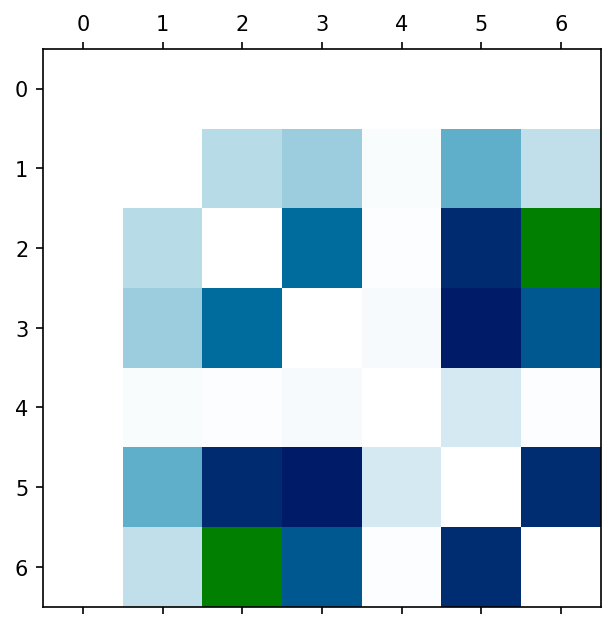

In [134]:
minfo_original = original_minfo(combined_tbt)
print(minfo_original)
plt.matshow(minfo_original, cmap='ocean_r')
plt.gcf().set_dpi(150)
plt.show()

[[0.00000000e+00 2.48909290e-01 6.42892643e-02 4.58214896e-01
  1.04489941e-02 1.02060856e-01 1.90899904e-04]
 [2.48909290e-01 0.00000000e+00 2.95493868e-02 3.58524070e-01
  5.65747625e-03 2.00933895e-01 6.73347177e-04]
 [6.42892643e-02 2.95493868e-02 0.00000000e+00 3.84098387e-01
  4.44196294e-03 5.13521517e-01 4.19170695e-04]
 [4.58214896e-01 3.58524070e-01 3.84098387e-01 0.00000000e+00
  2.43586419e-02 3.09497373e-03 8.65322557e-04]
 [1.04489941e-02 5.65747625e-03 4.44196294e-03 2.43586419e-02
  0.00000000e+00 1.61248196e-03 2.48417694e-03]
 [1.02060856e-01 2.00933895e-01 5.13521517e-01 3.09497373e-03
  1.61248196e-03 0.00000000e+00 9.98504871e-04]
 [1.90899904e-04 6.73347177e-04 4.19170695e-04 8.65322557e-04
  2.48417694e-03 9.98504871e-04 0.00000000e+00]]


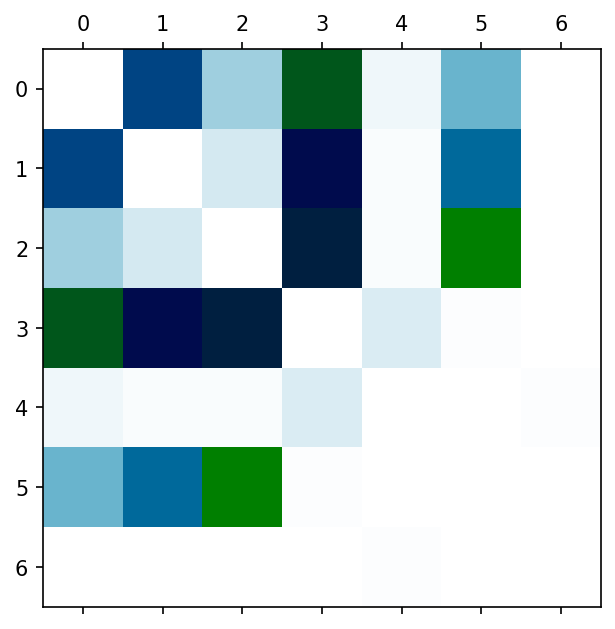

In [135]:
minfo_optimized = get_optimized_minfo(res.x)
print(minfo_optimized)
plt.matshow(minfo_optimized, cmap='ocean_r')
plt.gcf().set_dpi(150)
plt.show()

In [136]:
obj1 = get_objective_value(minfo_original)
obj2 = get_objective_value(minfo_optimized)
print(obj1, obj2)

1.1006885833197486 0.11414826887317026


In [137]:
obt, tbt = get_optimized_tensor(res.x)

In [138]:
print(obt)

[[-0.21390949 -0.09697554  0.07120901  0.15569706  0.14594788  0.05952647
  -0.19577271]
 [-0.09697554 -0.26892752  0.03031182  0.11453145  0.13781381  0.13792509
  -0.18565889]
 [ 0.07120901  0.03031182 -0.17277297  0.00824337 -0.0020634  -0.00876591
   0.03127259]
 [ 0.15569706  0.11453145  0.00824337 -0.25954198 -0.08155729 -0.10352254
   0.22656222]
 [ 0.14594788  0.13781381 -0.0020634  -0.08155729 -0.29350096 -0.06914181
   0.24227593]
 [ 0.05952647  0.13792509 -0.00876591 -0.10352254 -0.06914181 -0.12155864
   0.13233174]
 [-0.19577271 -0.18565889  0.03127259  0.22656222  0.24227593  0.13233174
  -0.53794489]]


In [139]:
label = "_optimized"
filename = "fcidump.H2O_10" + f"{label}"
pyscf.tools.fcidump.from_integrals(
    "fcidump_output"/Path(filename),
    obt,
    tbt,
    nmo=obt.shape[0],
    nelec=n_elec,
    nuc=ecore,
    ms=spin,
    orbsym=None,
    tol=1E-8,
    float_format=' %.16g',
)